주어진 데이터셋을 차원 축소한 뒤 **다양한 알고리즘**을 적용하여 클러스터링을 진행하고, 결과를 시각화하는 작업을 직접 해보면서 **비지도학습** (Unsupervised Learning)에 대한 이해도를 높여 봅시다.

In [185]:
## 필요한 라이브러리를 임포트합니다.

import pandas as pd
import numpy as np

In [186]:
## 시각화 관련 라이브러리를 임포트합니다.

from matplotlib import pyplot as plt
import seaborn as sns

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###데이터

사용할 데이터: 'Marketing Campaign.csv'

주어진 데이터는 마케팅 캠페인을 펼치고자 하는 소비자들에 대한 정보를 나타낸 데이터입니다. 해당 소비자들을 알맞게 군집화시키는 것이 우리의 목적입니다.

총 29개의 column으로 구성되어 있습니다. 



---







데이터에 대한 자세한 설명은 해당 kaggle 페이지에서 확인하실 수 있습니다.

https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign

데이터를 불러옵니다.

In [188]:
## drive에 있는 데이터셋을 불러오기 위해 드라이브와 연동을 합니다.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [189]:
## 'Marketing_campaign' 데이터의 위치를 불러와 저장합니다.

data = pd.read_csv('/content/drive/MyDrive/DSL/세션/[0209] Clustering 실습 및 과제 자료/marketing_campaign.csv', \
                   sep = ';')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### 데이터 전처리

In [191]:
## 등록한 이후에 현재까지의 기간(회원 일수)를 'days'라는 변수로 저장.
from datetime import datetime
now = pd.to_datetime(datetime.today().strftime("%Y-%m-%d")) #datetime 타입으로 변환

data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])
data['days'] = now - data.Dt_Customer
data['days'] = data['days'] / np.timedelta64(1, 'D')
data['days'] = data['days'].astype('int')
data['days'].head(3)

0    3814
1    3264
2    3463
Name: days, dtype: int64

In [192]:
## 나이를 age에 저장
data['age'] = 2024-data['Year_Birth']

In [193]:
## 마케팅 캠페인에서의 총 참여 횟수
data['CampaignAttendance'] = data.iloc[:,20:25].sum(axis =1)
## 이 데이터랑 군집화 결과가 얼마나 유사하게, 또는 다르게 나오는지 비교해봅시다~!!

In [194]:
data.columns

features = ['days', 'age', 'Income', 'Recency', 'MntWines', 'MntFruits',\
                     'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',\
                     'MntGoldProds', 'NumDealsPurchases','NumWebPurchases', \
                     'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',\
                    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',\
                    'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response','CampaignAttendance'] #우리가 고려할 변수들

In [195]:
X_features = data[features]
X_features = X_features.dropna().reset_index(drop = True) #결측치 제거

y_label = X_features['CampaignAttendance'] #캠페인에서의 총 참여 횟수를 임의의 라벨값으로 설정 -> 기준으로 삼아보자.

X_features = X_features.drop(['CampaignAttendance'], axis = 1)

In [196]:
## 각 변수들을 '표준화' scaling 합니다.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_features_scaling  = scaler.fit_transform(X_features)

X_features_scaling = pd.DataFrame(X_features_scaling, columns = X_features.columns, index = list(X_features.index.values))

###차원 축소

데이터를 차원 축소 해봅시다.

In [197]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## LDA (선형 지도 학습) 
lda = LinearDiscriminantAnalysis(n_components = 2)
X_train_lda = lda.fit_transform(X_features_scaling, y_label) #차원축소 과정에 y 라벨값을 입력해줌

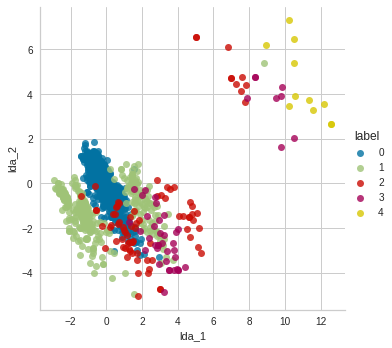

         lda_1     lda_2  label
0     1.136967 -1.804852      0
1    -0.390107  0.562877      0
2    -0.492550  0.143637      0
3    -0.353401  0.644298      0
4    -0.208290  0.529871      0
...        ...       ...    ...
2211  0.528615 -1.351187      0
2212  1.412328  0.439092      1
2213 -0.421907 -2.493652      1
2214 -0.353032 -0.057959      0
2215  0.429144 -0.207797      0

[2216 rows x 3 columns]


In [198]:
X_train_lda = pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda = pd.concat((X_train_lda, y_label), axis = 1) #X_train_lda와 y_label 데이터를 하나로 합치기
X_train_lda.columns = ['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x = 'lda_1',y = 'lda_2',data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

print(X_train_lda)
## 우리가 원하는 정답 모양
## 캠페인 참여에서의 총 참여 횟수를 라벨값으로 둔 상태에서의 데이터 분포도

###K-means Clustering

클러스터링을 돌려 보는 데에 의의가 있기에, 파라미터 값 최적화보다는 각 알고리즘을 사용하면 결과가 어떻게 달라지는 지에 초점을 맞추어 살펴봅니다. 여러 번 시행해보면서 **자유롭게 파라미터를 정해주세요**.

**(직접 최적의 파라미터 값을 찾아서 설정하고 싶으시다면 훨씬 좋습니다! 해당 과제의 모든 코드는 기본 뼈대일 뿐입니다. 코드를 추가 또는 변경하셔도 좋습니다.)**

다른 x값들에 대해서도 캠페인 참여도, 즉 고객의 충실도를 잘 군집화할 수 있을까요? 클러스터링으로 결과를 확인해봅시다.



---





K-means를 이용하여 클러스터링 해봅시다.

In [206]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import KMeans

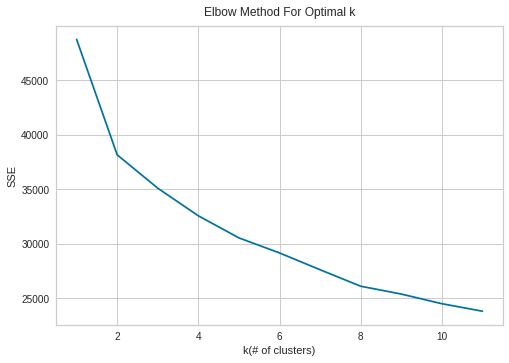

In [207]:
## 필요한 라이브러리를 임포트합니다.

from yellowbrick.cluster import KElbowVisualizer #elbow method

## Elbow method의 x값은 군집 수, y값은 원하는 지표 (내부평가) 사용이 가능합니다.
# 가장 구현이 간편한 SSE를 내부 평가 지표로 삼아 구현해봅시다.

sse = []
K = range(1, 12)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(X_features_scaling)
  sse.append(km.inertia_)

plt.plot(K, sse)
plt.xlabel('k(# of clusters)')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k', pad = 10)
plt.show()

elbow 포인트가 2에서 생깁니다

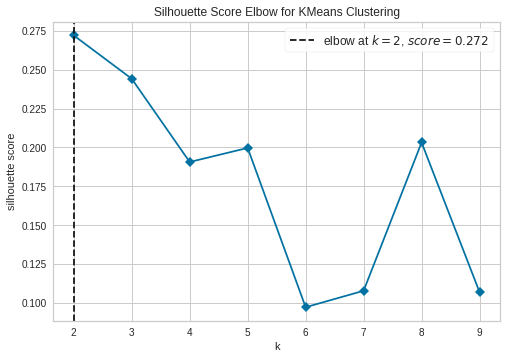

In [208]:
model = KMeans()

# 실루엣 계수는 '2 <= # of labels <= (# of samples) - 1' 일 때에만 정의됩니다.
elbowvisualizer = KElbowVisualizer(model, k = (2,10), metric = 'silhouette', timings = False)

elbowvisualizer.fit(X_features_scaling)  
elbowvisualizer.show()

elbow point가 2에서 발생함을 알 수 있습니다

In [209]:
## 클러스터 수는 ########(숫자)########로 설정하고, KMeans를 활용하여 예측된 y값을 만들어 봅시다.

km = KMeans(n_clusters = 2)

y_km = km.fit_predict(X_features_scaling)
y_km

array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

In [210]:
X_train_lda['K_means'] = y_km

####시각화

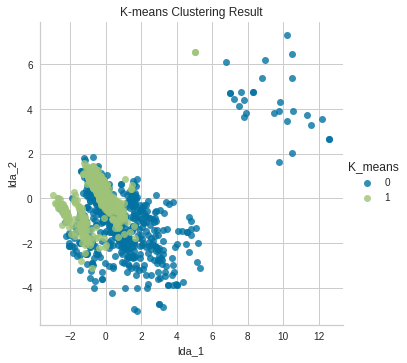

In [211]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

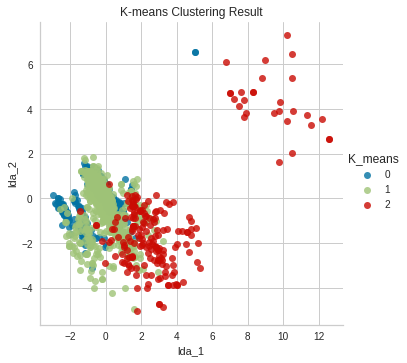

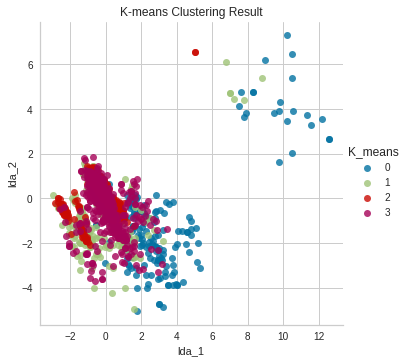

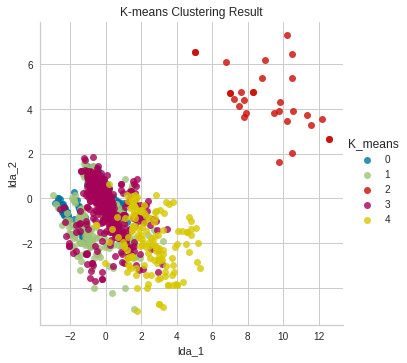

In [212]:
km = KMeans(n_clusters = 3)
y_km = km.fit_predict(X_features_scaling)
X_train_lda['K_means'] = y_km
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

km = KMeans(n_clusters = 4)
y_km = km.fit_predict(X_features_scaling)
X_train_lda['K_means'] = y_km
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

km = KMeans(n_clusters = 5)
y_km = km.fit_predict(X_features_scaling)
X_train_lda['K_means'] = y_km
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'K_means', fit_reg = False)
plt.title('K-means Clustering Result')
plt.show()

###Hierarchical Clustering

Agglomerative 방법을 이용하여 클러스터링 해봅시다.

In [213]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import AgglomerativeClustering

In [214]:
## 클러스터 수는 ########(숫자)########로 설정하고, Agglomerative를 활용하여 예측된 y값을 만들어 봅시다.

agghc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward') #와드연결법을 사용합니다.
y_agghc = agghc.fit_predict(X_features_scaling)
y_agghc

array([2, 3, 2, ..., 1, 2, 1])

In [215]:
X_train_lda['hierarchical'] = y_agghc

####시각화

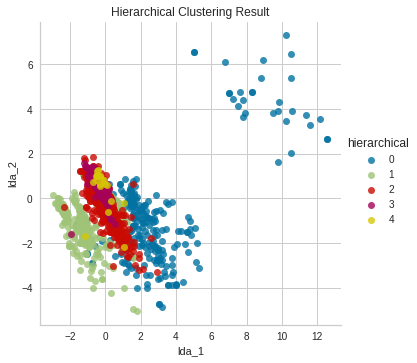

In [216]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'hierarchical', fit_reg = False)
plt.title('Hierarchical Clustering Result')
plt.show()

###DBSCAN

DBSCAN을 이용하여 클러스터링 해봅시다.

In [217]:
## 필요한 라이브러리를 임포트합니다.

from sklearn.cluster import DBSCAN
import sklearn.utils
import sklearn.neighbors
from sklearn.neighbors import NearestNeighbors

In [218]:
nb = NearestNeighbors(n_neighbors = 4).fit(X_features_scaling)
minPts = 4

In [219]:
#kneighbors([X, n_neighbors, return_distance]): Find the K-neighbors of a point.
distances, indices = nb.kneighbors(X_features_scaling)

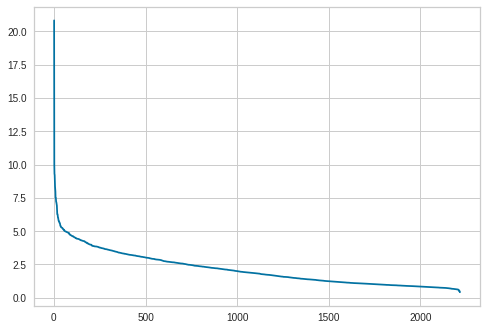

In [220]:
distance = sorted(distances[:, minPts-1], reverse = True)
plt.plot(list(range(1,2217)), distance)

epsilon이 대략 5인 지점이 threshold로 보인다

In [221]:
## eps는 ########(숫자)########, minPts는 ########(숫자)########로 설정한 뒤 DBSCAN를 활용하여 예측된 y값을 만들어 봅시다.

dbscan = DBSCAN(eps = 5.5, min_samples = 4, metric = 'euclidean') #eps는 0-1

y_dbscan = dbscan.fit(X_features_scaling)
y_db = y_dbscan.labels_

In [222]:
## DBSCAN 결과 나온 라벨 값을 데이터에 저장합니다.
X_train_lda['dbscan'] = y_dbscan.labels_

In [223]:
# 실제 클러스터 수

cluster_db = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
cluster_db

4

####시각화

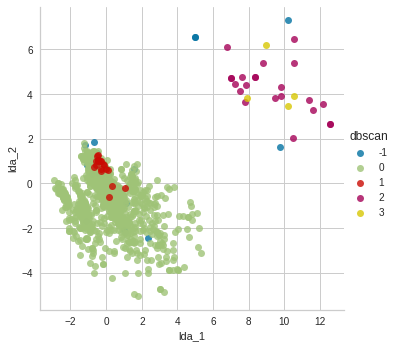

In [224]:
sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'dbscan', fit_reg = False)
plt.show()

###Validation

실루엣 계수를 사용하여 각 클러스터링의 성능을 평가해봅시다.



---



(Q) 실루엣 계수로 평가하기 전에, 육안 상으로 어떠한 알고리즘의 성능이 제일 높아 보이며 어떠한 알고리즘의 성능이 제일 낮아 보이는지 의견을 적어주세요.

K-means의 성능이 제일 나아보인다.



---



이제 실루엣 계수로 성능을 평가해 봅시다!

In [178]:
## 필요한 라이브러리를 임포트합니다.

import sklearn.metrics as metrics
from sklearn.metrics.cluster import silhouette_score

K-means Clustering의 실루엣 계수입니다.

In [179]:
coef_km = metrics.silhouette_score(X_features_scaling, y_km)
print('Silhouette score is {}.'.format(coef_km))

Silhouette score is 0.1961861834136571.


Hierarchical Clustering의 실루엣 계수입니다.

In [180]:
## Hierarchical Clustering

coef_hc = metrics.silhouette_score(X_features_scaling, y_agghc)
print('Silhouette score is {}.'.format(coef_hc))

Silhouette score is 0.17365845170676658.


DBSCAN의 실루엣 계수입니다.

In [181]:
## DBSCAN

coef_db = metrics.silhouette_score(X_features_scaling, y_db)
print('Silhouette score is {}.'.format(coef_db))

Silhouette score is 0.4928237530953137.


(Q) 실루엣 계수를 기반으로, 클러스터링 알고리즘의 성능을 높은 순대로 적어주세요.

DBSCAN,Kmeans,hierarchical

(Q) 클러스터링 결과에 대한 해석을 적어주세요. (참고로, 실루엣 계수는 -1에서 1 사이의 값을 가집니다.)

DBSCAN이 육안으로는 좋은 결과로 보이지 않았으나 실루엣 계수 값이 큰 것을 보면, 애초에 캠페인 총 참여 횟수인 y label이 비지도학습으로는 분류하기 어려운 데이터가 아니었나 싶다. 거리 상으로 구분된다고 하여 그것이 총 참여횟수의 분류로 이어지지 않음을 알 수 있다. <br> 또한 2차원 lda로 시각화한 그래프가 데이터를 온전히 담지 못했을 가능성 역시 존재한다. 


(Q) 마케팅 캠페인과 관련하여 도출할 수 있는 인사이트를 적어주세요.

캠페인 총 참여 회수는 위에 제공된 변수들을 통해서 clustering하기에 어려운 데이터이다. 다른 변수를 추가적으로 찾아야 할 필요성이 있다. 